# Project: ADS 505: Deep Learning


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

In [3]:
!pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms




In [5]:
path = "/content/drive/MyDrive/Colab_Notebooks/ADS_505/Module_3/final_dataset2.csv"

# Reload the dataset
final_dataset = pd.read_csv(path)

# Select the most recent column for PriceToRentRatio
latest_price_to_rent_ratio_column = "PriceToRentRatio_2017-09"

# Extract the relevant column for PriceToRentRatio and drop NaNs
relevant_column = final_dataset[[latest_price_to_rent_ratio_column]].dropna()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(relevant_column)

# Create a DataFrame for the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=[latest_price_to_rent_ratio_column])

# Use the normalized Price-to-Rent Ratio as both "Normalized Low House Price" and "Normalized High Rent"
normalized_df['Normalized_Low_House_Price'] = normalized_df[latest_price_to_rent_ratio_column]
normalized_df['Normalized_High_Rent'] = normalized_df[latest_price_to_rent_ratio_column]

# Calculate the new composite score
weights = [0.5, 0.5]  # Assuming equal weights for low house price and high rent
normalized_df['New_Composite_Score'] = normalized_df[['Normalized_Low_House_Price', 'Normalized_High_Rent']].dot(weights)

# Sort the DataFrame by the new composite score in ascending order (lower score is better based on our criteria)
sorted_df_new = normalized_df.sort_values(by='New_Composite_Score')

# Add the new composite score to the original DataFrame
final_dataset['New_Composite_Score'] = None  # Initialize the new column with None values
final_dataset.loc[sorted_df_new.index, 'New_Composite_Score'] = sorted_df_new['New_Composite_Score'].values

# drop one columns named "PriceToRentRatio_2017-09"
final_dataset2=final_dataset.drop(columns=["PriceToRentRatio_2017-09"])


final_dataset2.shape


<ipython-input-5-10cf74be5906>:32: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_dataset.loc[sorted_df_new.index, 'New_Composite_Score'] = sorted_df_new['New_Composite_Score'].values


(14233, 167)

In [6]:
final_dataset2.head()

,MortgageRateConventionalFixed_2011-06,MortgageRateConventionalFixed_2011-07,MortgageRateConventionalFixed_2011-08,MortgageRateConventionalFixed_2011-09,MortgageRateConventionalFixed_2011-10,MortgageRateConventionalFixed_2011-11,MortgageRateConventionalFixed_2011-12,MortgageRateConventionalFixed_2012-01,MortgageRateConventionalFixed_2012-02,MortgageRateConventionalFixed_2012-03,...,PriceToRentRatio_2017-07,PriceToRentRatio_2017-08,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,New_Composite_Score
0,4.374217,4.460115,4.127827,3.963005,4.035497,3.941695,3.85004,3.815944,3.808312,3.931269,...,10.59,10.64,58196,1001,Agawam,MA,Springfield,Hampden,5770,0.243539
1,4.374217,4.460115,4.127827,3.963005,4.035497,3.941695,3.85004,3.815944,3.808312,3.931269,...,12.77,12.94,58197,1002,Amherst,MA,Springfield,Hampshire,4112,0.317422
2,4.374217,4.460115,4.127827,3.963005,4.035497,3.941695,3.85004,3.815944,3.808312,3.931269,...,11.26,11.36,58200,1005,Town of Barre,MA,Worcester,Worcester,11428,0.267254
3,4.374217,4.460115,4.127827,3.963005,4.035497,3.941695,3.85004,3.815944,3.808312,3.931269,...,12.96,12.94,58201,1007,Town of Belchertown,MA,Springfield,Hampshire,6855,0.305868
4,4.374217,4.460115,4.127827,3.963005,4.035497,3.941695,3.85004,3.815944,3.808312,3.931269,...,11.97,11.98,58202,1008,Blandford,MA,Springfield,Hampden,15088,0.281545


In [7]:
# calculating missing value for each column as a percentages

missing_percentage = final_dataset2.isnull().sum()/ len(final_dataset2)*100

# Display columns with missing values and their respective percentages
missing_percentage[missing_percentage > 0].sort_values(ascending=False)


PriceToRentRatio_2010-11    8.318696
PriceToRentRatio_2010-10    6.983770
PriceToRentRatio_2010-12    6.365489
PriceToRentRatio_2011-03    5.086770
PriceToRentRatio_2012-08    4.925174
                              ...   
PriceToRentRatio_2016-11    1.524626
PriceToRentRatio_2017-01    1.517600
PriceToRentRatio_2017-02    1.503548
PriceToRentRatio_2017-03    1.496522
PriceToRentRatio_2017-04    0.266985
Length: 79, dtype: float64

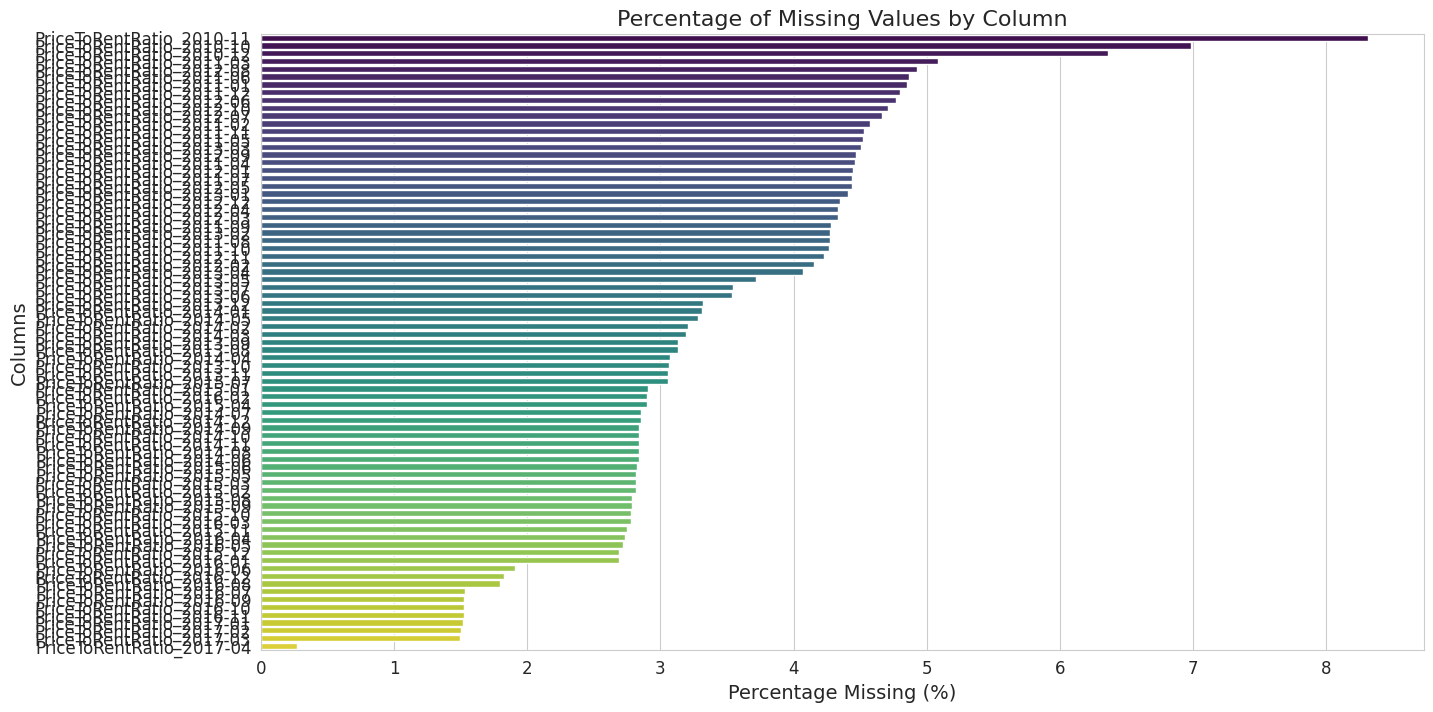

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the aesthetics for the plot
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))

# Plotting the histogram
missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
sns.barplot(y=missing_data.index, x=missing_data.values, palette="viridis")

# Setting up the title and labels
plt.title('Percentage of Missing Values by Column', fontsize=16)
plt.xlabel('Percentage Missing (%)', fontsize=14)
plt.ylabel('Columns', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


We will use the dataset for the LSTM- CNN-based and different Transformer based models. That's why we need to handle missing values properly. Impute the missing values with mean() and median() may hamper the model and it will cause bias in the model. Deleting this large amount of rows will cause a huge amount of information loss. </br>

We will use `linear Interpolation` methods to handle the missing values.


In [9]:
# Use linear interpolation to impute missing values
dataset2 = final_dataset2.interpolate(method="linear", axis=0)
print(f"number of missing value is {dataset2.isnull().sum().sum()}")

number of missing value is 0


In [10]:
# columns to drop
# Drop columns with the keyword "MortgageRate" from the dataset
dataset2_cleaned =  dataset2.iloc[:, 76:]
dataset2_cleaned.shape

(14233, 91)

In [11]:
dataset2_cleaned.head()

,PriceToRentRatio_2010-10,PriceToRentRatio_2010-11,PriceToRentRatio_2010-12,PriceToRentRatio_2011-01,PriceToRentRatio_2011-02,PriceToRentRatio_2011-03,PriceToRentRatio_2011-04,PriceToRentRatio_2011-05,PriceToRentRatio_2011-06,PriceToRentRatio_2011-07,...,PriceToRentRatio_2017-07,PriceToRentRatio_2017-08,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,New_Composite_Score
0,11.48,11.47,11.46,11.26,11.15,11.46,10.79,10.37,10.24,10.10,...,10.59,10.64,58196,1001,Agawam,MA,Springfield,Hampden,5770,0.243539
1,13.98,13.89,13.94,13.93,13.98,13.92,14.61,15.11,14.97,14.13,...,12.77,12.94,58197,1002,Amherst,MA,Springfield,Hampshire,4112,0.317422
2,11.09,11.34,11.56,11.70,12.11,12.19,12.05,11.65,11.36,11.22,...,11.26,11.36,58200,1005,Town of Barre,MA,Worcester,Worcester,11428,0.267254
3,12.95,12.88,12.87,12.86,12.72,12.29,12.44,12.64,12.37,11.81,...,12.96,12.94,58201,1007,Town of Belchertown,MA,Springfield,Hampshire,6855,0.305868
4,12.77,12.66,12.61,12.63,12.16,12.98,12.41,11.94,11.68,11.45,...,11.97,11.98,58202,1008,Blandford,MA,Springfield,Hampden,15088,0.281545


In [12]:
# Assign unique identifiers
dataset2_cleaned['ID'] = range(1, len(dataset2_cleaned) + 1)

# Convert specified columns to 'category' type
categorical = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName']
dataset2_cleaned[categorical] = dataset2_cleaned[categorical].astype('category')

# Separate numerical and categorical data
numerical_data = dataset2_cleaned.drop(columns=categorical)
categorical_data = dataset2_cleaned[categorical + ['ID']]

In [13]:
# Drop the 'RegionID' and 'RegionName' columns
reduced_categorical_data = dataset2_cleaned.drop(columns=["RegionID", "RegionName"])

# One-hot encode the remaining categorical columns
encoded_data = pd.get_dummies(reduced_categorical_data)

# Attach the numerical data to the encoded categorical data
final_encoded_data = pd.concat([numerical_data, encoded_data], axis=1)

# Drop the 'ID' and 'Cluster' columns from final encoded data
final_encoded_data.shape #= final_encoded_data.drop(columns=["ID", "Cluster"])

#final_encoded_data.head()


(14233, 9537)

In [14]:

final_encoded_data.head()

,PriceToRentRatio_2010-10,PriceToRentRatio_2010-11,PriceToRentRatio_2010-12,PriceToRentRatio_2011-01,PriceToRentRatio_2011-02,PriceToRentRatio_2011-03,PriceToRentRatio_2011-04,PriceToRentRatio_2011-05,PriceToRentRatio_2011-06,PriceToRentRatio_2011-07,...,CountyName_Yankton,CountyName_Yates,CountyName_Yavapai,CountyName_Yazoo,CountyName_Yellowstone,CountyName_Yolo,CountyName_York,CountyName_Yuba,CountyName_Yuma,CountyName_Zapata
0,11.48,11.47,11.46,11.26,11.15,11.46,10.79,10.37,10.24,10.10,...,0,0,0,0,0,0,0,0,0,0
1,13.98,13.89,13.94,13.93,13.98,13.92,14.61,15.11,14.97,14.13,...,0,0,0,0,0,0,0,0,0,0
2,11.09,11.34,11.56,11.70,12.11,12.19,12.05,11.65,11.36,11.22,...,0,0,0,0,0,0,0,0,0,0
3,12.95,12.88,12.87,12.86,12.72,12.29,12.44,12.64,12.37,11.81,...,0,0,0,0,0,0,0,0,0,0
4,12.77,12.66,12.61,12.63,12.16,12.98,12.41,11.94,11.68,11.45,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Scaling the entire dataset using MinMaxScaler
scaler_full = MinMaxScaler()
scaled_data = scaler_full.fit_transform(final_encoded_data)

# Convert the scaled data back to a DataFrame for better readability and operations
scaled_df = pd.DataFrame(scaled_data, columns=final_encoded_data.columns)

# Checking the first few rows of the scaled data
scaled_df.head()


,PriceToRentRatio_2010-10,PriceToRentRatio_2010-11,PriceToRentRatio_2010-12,PriceToRentRatio_2011-01,PriceToRentRatio_2011-02,PriceToRentRatio_2011-03,PriceToRentRatio_2011-04,PriceToRentRatio_2011-05,PriceToRentRatio_2011-06,PriceToRentRatio_2011-07,...,CountyName_Yankton,CountyName_Yates,CountyName_Yavapai,CountyName_Yazoo,CountyName_Yellowstone,CountyName_Yolo,CountyName_York,CountyName_Yuba,CountyName_Yuma,CountyName_Zapata
0,0.286408,0.286641,0.288368,0.285057,0.291060,0.303109,0.273408,0.252174,0.277274,0.275034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.367314,0.365110,0.369176,0.372742,0.384768,0.382772,0.392634,0.394303,0.436052,0.411367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.273786,0.282425,0.291626,0.299507,0.322848,0.326749,0.312734,0.290555,0.314871,0.312923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333981,0.332361,0.334311,0.337603,0.343046,0.329987,0.324906,0.320240,0.348775,0.332882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.328155,0.325227,0.325839,0.330049,0.324503,0.352332,0.323970,0.299250,0.325613,0.320704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
class Autoencoder (nn.Module):
  def __init__(self):
    super(Autoencoder, self). __init__()

    self.encoder = nn.Sequential(
        nn.Linear (9537, 4000),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear (4000, 2000),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear (2000, 1000),
        nn.ReLU(True),
        nn.Dropout(0.5)
    )

    self.decoder = nn.Sequential(
        nn.Linear (1000, 2000),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(2000, 4000),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(4000,9537),
        nn.ReLU(True)
        )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

- step 1: nn architect
- step 2: data jeita dhukbe take torch e convert kore nite hobe. general data torch diye nn e dhukte pare na.
- step 3: data model e dhukbe
- step 4: age loss then backprop by optimizer ()
- step 5: loop for updating the weight to find the best optimization point.

In [18]:
data_tensor = torch.FloatTensor(scaled_df.values)

print(final_encoded_data.shape)
data_tensor.shape

(14233, 9537)


torch.Size([14233, 9537])

Epoch [1/50], Train Loss: 0.0018, Validation Loss: 0.0006
Epoch [2/50], Train Loss: 0.0006, Validation Loss: 0.0005
Epoch [3/50], Train Loss: 0.0006, Validation Loss: 0.0005
Epoch [4/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [5/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [6/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [7/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [8/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [9/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [10/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [11/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [12/50], Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [13/50], Train Loss: 0.0005, Validation Loss: 0.0004
Epoch [14/50], Train Loss: 0.0005, Validation Loss: 0.0004
Epoch [15/50], Train Loss: 0.0005, Validation Loss: 0.0004
Epoch [16/50], Train Loss: 0.0004, Validation Loss: 0.0004
Epoch [17/50], Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 

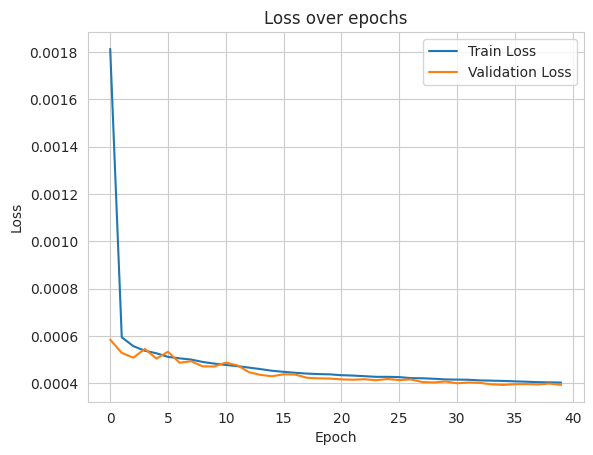

In [73]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data_tensor))
val_size = len(data_tensor) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data_tensor, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Parameters for early stopping
patience = 5
epochs_no_improve = 0
min_val_loss = float('inf')  # Initialize with a high value

# Lists to store losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0

    for batch_data in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_data in val_loader:
            outputs = model(batch_data)
            loss = criterion(outputs, batch_data)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Early stopping logic
    if avg_val_loss < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = avg_val_loss
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plotting the train and validation loss over epochs
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [76]:

# Define the save path
save_path = "/content/drive/MyDrive/Colab_Notebooks/ADS_505/Module_3/autoencoder_505.pth"

# Save the entire encoder model
torch.save(model.encoder, save_path)


In [ ]:
with torch.no_grad():
    embeddings = model.encoder(data_tensor)

In [101]:
# Convert the tensor to a numpy array and then to a DataFrame
embeddings_df = pd.DataFrame(embeddings.cpu().numpy())

In [20]:
path = "/content/drive/MyDrive/Colab_Notebooks/ADS_505/Module_3/embeddings_505.csv"

embeddings_df = pd.read_csv(path)
print(embeddings_df.shape)


(14233, 1000)


In [21]:
from sklearn.cluster import KMeans

# Using KMeans for clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings_df)

# Attach clusters to embeddings
embeddings_df['Cluster'] = clusters

# Attach relevant metadata from the original dataset to the embeddings
result_df = pd.concat([dataset2_cleaned[['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'New_Composite_Score']], embeddings_df], axis=1)

result_df.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(14233, 1008)

In [22]:
# Analyzing each cluster's average and median "New_Composite_Score"

cluster_analysis = result_df.groupby('Cluster')['New_Composite_Score'].agg(['mean', 'median', 'count'])

# Sort by mean score for presentation
cluster_analysis = cluster_analysis.sort_values(by='mean')

cluster_analysis

,mean,median,count
Cluster,,,
4,0.115410,0.113712,452
2,0.115510,0.118273,311
0,0.190486,0.190939,3094
3,0.234104,0.233050,516
1,0.321636,0.296747,9860


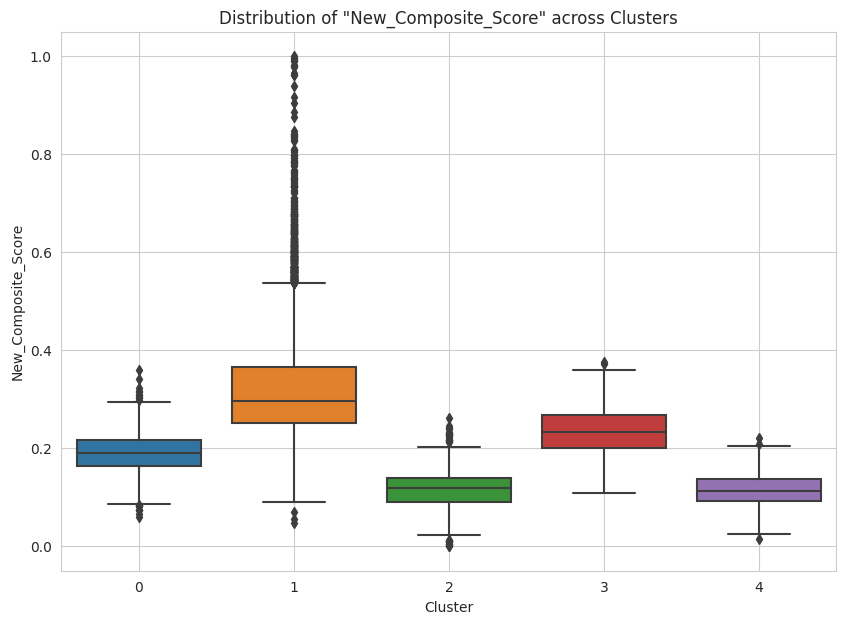

In [23]:
import matplotlib.pyplot as plt

# Boxplot of 'New_Composite_Score' for each cluster
plt.figure(figsize=(10, 7))
sns.boxplot(x='Cluster', y='New_Composite_Score', data=result_df)
plt.title('Distribution of "New_Composite_Score" across Clusters')
plt.ylabel('New_Composite_Score')
plt.xlabel('Cluster')
plt.grid(True)
plt.show()


In [24]:
# Analyzing the geographical distribution of properties in each cluster

# Top counties for each cluster
top_counties = result_df.groupby('Cluster')['CountyName'].value_counts().groupby('Cluster').head(5)

# Top cities for each cluster
top_cities = result_df.groupby('Cluster')['City'].value_counts().groupby('Cluster').head(5)

# Top metros for each cluster
top_metros = result_df.groupby('Cluster')['Metro'].value_counts().groupby('Cluster').head(5)


# Convert the series into dataframes
top_counties_df = top_counties.reset_index(name='Count')
top_cities_df = top_cities.reset_index(name='Count')
top_metros_df = top_metros.reset_index(name='Count')

# Pivot the tables for a clearer presentation
top_counties_pivot = top_counties_df.pivot(index='CountyName', columns='Cluster', values='Count').fillna(0)
top_cities_pivot = top_cities_df.pivot(index='City', columns='Cluster', values='Count').fillna(0)
top_metros_pivot = top_metros_df.pivot(index='Metro', columns='Cluster', values='Count').fillna(0)

# Add a ranking column for each category and reformat the dataframes

# For top counties
top_counties_df['Rank'] = top_counties_df.groupby('Cluster')['Count'].rank(ascending=False, method='first').astype(int)
top_counties_table = top_counties_df.pivot(index='Rank', columns='Cluster', values='CountyName')

# For top cities
top_cities_df['Rank'] = top_cities_df.groupby('Cluster')['Count'].rank(ascending=False, method='first').astype(int)
top_cities_table = top_cities_df.pivot(index='Rank', columns='Cluster', values='City')

# For top metros
top_metros_df['Rank'] = top_metros_df.groupby('Cluster')['Count'].rank(ascending=False, method='first').astype(int)
top_metros_table = top_metros_df.pivot(index='Rank', columns='Cluster', values='Metro')

top_counties_table


Cluster,0,1,2,3,4
Rank,,,,,
1,Cook,Los Angeles,Suffolk,Oakland,Wayne
2,Jefferson,Orange,Oswego,Macomb,Cook
3,Madison,Washington,Clinton,Wayne,Cuyahoga
4,Monroe,Middlesex,Saint Lawrence,Kent,Jefferson
5,Marion,Jefferson,Steuben,Genesee,Schuylkill


In [25]:
top_cities_table

Cluster,0,1,2,3,4
Rank,,,,,
1,Chicago,New York,Rochester,Flint,Detroit
2,Indianapolis,Los Angeles,Buffalo,Grand Rapids,Cleveland
3,Columbus,Phoenix,Syracuse,Lansing,Memphis
4,Oklahoma City,Las Vegas,Town of Elmira,Farmington Hills,Birmingham
5,Tulsa,San Diego,Town of Islip,Saginaw,Toledo


In [26]:
top_metros_table

Cluster,0,1,2,3,4
Rank,,,,,
1,Chicago,New York,New York,Detroit,Chicago
2,Pittsburgh,Los Angeles-Long Beach-Anaheim,Rochester,Grand Rapids,Detroit
3,Dallas-Fort Worth,Boston,Syracuse,Lansing,St. Louis
4,Miami-Fort Lauderdale,Washington,Utica,Kalamazoo,Miami-Fort Lauderdale
5,Philadelphia,Philadelphia,Plattsburgh,Flint,Cleveland


`Business Recommendation for Real Estate Investment:`

When it comes to real estate, the key is diversification, and our clusters offer a roadmap for this. Each cluster we've identified presents unique investment opportunities:


1. `Cluster 0:` This cluster predominantly features properties from places like Chicago and Columbus. Here, we have a balanced investment opportunity. It's like a steady stock in the portfolio - not too volatile but promises decent Returns. Cities like Chicago could be our pick if we are looking for good, consistent growth.


2. `Cluster 1:` Think of this as the luxury segment of our portfolio. It's dominated by global giants like New York and Los Angeles. Immediate returns might not be sky-high, but these are properties in cities that always remain in demand. They're the golden geese, steadily appreciating over time. For those thinking long-term and wanting assets that promise value year after year, this cluster is a must-have.

3. `Cluster 2:` This is our high-growth stock. Properties in places like Rochester promise the best short-term returns. If quick, high returns are what we're after, don't miss out on this cluster. It's the one that could give our portfolio an immediate boost.

4. `Cluster 3:` Featuring cities in Michigan like Flint, this cluster is the middle child. It might not offer the high-speed growth of Cluster 2 or the prestige of Cluster 1, but it's consistent. It's the kind of cluster we invest in for a mix of moderate growth and stability.

5. `Cluster 4:` A mix of dynamic locations like Detroit and Cleveland make up this cluster. It's another high-return opportunity. If we're looking to maximize profit in the short to mid-term, ensure properties from this cluster are in our basket.

To craft a winning real estate strategy, spread our investments. Mix and match properties from these clusters. Prioritize Cluster 2 and 4 for quick wins, but ensure we have assets from Cluster 1 for long-term value. As with any investment, always do a ground check before putting in the company money. No matter how promising the numbers look, a physical inspection and local research can be invaluable.

# New Supervised model with CNN-LSTM

In [28]:
# Drop rows with the missing target variable "New_Composite_Score"
dataset = dataset2_cleaned.dropna(subset=["New_Composite_Score"])

# Separate the features (X) from the main dataset
target_column = "New_Composite_Score"
feature_columns = dataset.columns.difference([target_column])

X = embeddings_df  # Selecting only numerical columns for X
y = dataset[target_column].values.reshape(-1, 1)

print (X.shape)
print (y.shape)

(14233, 1001)
(14233, 1)


In [29]:
numerical_X = X.select_dtypes(include=[np.number])
if numerical_X.shape == X.shape:
    print("All values in X are numerical.")
else:
    non_numerical_cols = X.select_dtypes(exclude=[np.number]).columns
    print("The following columns in X are not numerical:", non_numerical_cols)


All values in X are numerical.


## preprocessing for applying neural network

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from skopt import BayesSearchCV
from skopt import gp_minimize
import logging
logging.basicConfig(level=logging.INFO)
from torch.utils.data import DataLoader, TensorDataset
from skopt import gp_minimize
import logging


# Drop rows with the missing target variable "New_Composite_Score"
dataset = dataset2_cleaned.dropna(subset=["New_Composite_Score"])

# Separate the features (X) from the main dataset
target_column = "New_Composite_Score"
feature_columns = dataset.columns.difference([target_column])

X = embeddings_df  # Selecting only numerical columns for X
y = dataset[target_column].values.reshape(-1, 1)

# Feature Scaling using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X.columns = X.columns.astype(str)
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


# Spliting the dataset

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.30, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)


X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)

y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)
y_test_tensor = torch.FloatTensor(y_test)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_val_tensor.shape)
print(y_val_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)



torch.Size([6974, 1001])
torch.Size([6974, 1])
torch.Size([2989, 1001])
torch.Size([2989, 1])
torch.Size([4270, 1001])
torch.Size([4270, 1])


In [31]:

class CNN_BiLSTM(nn.Module) :
    def __init__(self,num_lstm_layers, num_conv_layers, kernel_size, hidden_units, dropout_rate):
      super(CNN_BiLSTM, self).__init__()
      self.conv_layers = nn.ModuleList([
          nn.Conv1d(in_channels=1 if i==0 else 64, out_channels=64, kernel_size=kernel_size)
          for i in range(num_conv_layers)
      ])

      # Max Pooling Layer
      self.maxpool = nn.MaxPool1d(kernel_size=2)

      # Bi Directional LSTM layer
      self.lstm= nn.LSTM(input_size=64,
                         hidden_size=hidden_units,
                         num_layers = num_lstm_layers,
                         bidirectional=True)

      # fully connected layer for output
      self.fc = nn.Linear(2 * hidden_units, 1)
      self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):

      # step 1: reshape for COnv1D
      x = x.unsqueeze(1)

      #print(f"Step 1 shape: {x.shape}")


      # Conv1D layer expects input shape [batch_size, n_channels, sequence_length]
      # the dataset
      for conv in self.conv_layers:
        #print(f"Input shape: {x.shape}")  # Debugging line
        #x = x.permute(0,2,1)  # reshape to [batch_size, sequence_length, n_channels]
        #print(f"After first permute: {x.shape}")
        x = conv(x)
        x = self.maxpool(x)
        #print (f"After CNN shape of X: {x.shape}")


      # LSTM layer expects input shape [batch_size, sequence_length, n_channels]
      x = x.permute(2,0,1)

      # bidirectional LSTM
      x, _ = self.lstm(x)

      # Fully connected layer
      x = self.fc(x[-1,:,:])

      return x

## Finding the optimum hyperparamter

In [ ]:

# Define the hyperparameter space
param_space = {
    'learning_rate': (0.001, 0.1, 'log-uniform'),
    'batch_size': [16, 32, 64],
    'num_lstm_layers': [1, 2],
    'num_conv_layers': [1, 2],
    'kernel_size': [2, 3, 4],
    'hidden_units': [50, 100],
    'dropout_rate': [0, 0.2, 0.5]
}



def train_model(params):
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience = 5
    wait = 0

    learning_rate, batch_size, num_lstm_layers, num_conv_layers, kernel_size, hidden_units, dropout_rate = params
    model = CNN_BiLSTM(num_lstm_layers, num_conv_layers, kernel_size, hidden_units, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



    for epoch in range(10):  # You can choose a different maximum number of epochs
        logging.info(f"Starting epoch {epoch + 1}")
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        logging.info(f"Validation loss for epoch {epoch + 1}: {avg_val_loss}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                logging.info("Early stopping triggered")
                break

    return best_val_loss


#Define the search space
space = [
    (1e-3, 1e-1, "log-uniform"),  # learning rate
    (16, 64),  # batch size
    (1, 2),  # num_lstm_layers
    (1, 2),  # num_conv_layers
    (2, 4),  # kernel_size
    (50, 100),  # hidden_units
    (0.0, 0.5)  # dropout_rate
]

# Run Bayesian optimization
res = gp_minimize(train_model, space, n_calls=50, random_state=0)

# Extract best hyperparameters
best_params = res.x
best_params

It shows that after the hyperparameter tuning:
- learning_rate = 0.007562696289434611
- Batch_size = 45
- Lstm layer = 1
- Convolution layers = 1
- number of hidden layer = 100
- dropout rate = 0.05563689204925352

Training on the whole dataset to train the model

## Trial run in small dataset.

In [32]:
learning_rate = 0.001
Batch_size = 45
Lstm_layer = 2
Convolution_layers = 2
number_of_hidden_layer = 100
kernel_size = 2
dropout_rate = 0.20


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)


# Initialize the model with the optimized hyperparameters
model = CNN_BiLSTM(Lstm_layer, Convolution_layers, kernel_size, number_of_hidden_layer, dropout_rate)

# Define the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model using the optimized hyperparameters
num_epochs = 50  # or any other number you prefer
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()


    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/ len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

path = "/content/drive/MyDrive/Colab_Notebooks/ADS_505/Module_3/model_state_dict2.pth"
torch.save(model.state_dict(), path)

# After training, you can evaluate the model on the test set or save the model for future use.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([45, 1, 1])) that is different to the input size (torch.Size([45, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([44, 1, 1])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19, 1, 1])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

Epoch 1/50, Training Loss: 0.013541861329107516, Validation Loss: 0.012138424608022419
Epoch 2/50, Training Loss: 0.012616746211724896, Validation Loss: 0.012013786771237406
Epoch 3/50, Training Loss: 0.012430600167041825, Validation Loss: 0.011998500640212155
Epoch 4/50, Training Loss: 0.01241014906836133, Validation Loss: 0.011972221525024567
Epoch 5/50, Training Loss: 0.012407335801230324, Validation Loss: 0.011981511599759556
Epoch 6/50, Training Loss: 0.012443618184977, Validation Loss: 0.012060750519106192
Epoch 7/50, Training Loss: 0.012463040025003494, Validation Loss: 0.012092052868553508
Epoch 8/50, Training Loss: 0.012389063573772868, Validation Loss: 0.01196916297133734
Epoch 9/50, Training Loss: 0.012418490257715025, Validation Loss: 0.012003171765036992
Epoch 10/50, Training Loss: 0.012405376616985568, Validation Loss: 0.012004590051165267
Epoch 11/50, Training Loss: 0.012490122317666968, Validation Loss: 0.012002195210765992
Epoch 12/50, Training Loss: 0.0123756690671847

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([40, 1, 1])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Training Loss: 0.012363674140144741, Validation Loss: 0.011972776516827184, Test Loss: 0.012798296170015084
Epoch 2/50, Training Loss: 0.012391967864166345, Validation Loss: 0.012053246526464598, Test Loss: 0.012857704467483256
Epoch 3/50, Training Loss: 0.012352441545696027, Validation Loss: 0.011968974545320024, Test Loss: 0.012786315401133739
Epoch 4/50, Training Loss: 0.012363507217096706, Validation Loss: 0.01212931646089723, Test Loss: 0.01297219584352876
Epoch 5/50, Training Loss: 0.012372631435432742, Validation Loss: 0.011970263989225252, Test Loss: 0.01279490294523145
Epoch 6/50, Training Loss: 0.012343365392617642, Validation Loss: 0.01203185087069869, Test Loss: 0.012866611862064977
Epoch 7/50, Training Loss: 0.012367732759805456, Validation Loss: 0.0119768856857806, Test Loss: 0.012791527253820708
Epoch 8/50, Training Loss: 0.012339435301480755, Validation Loss: 0.011983630733925905, Test Loss: 0.012796558890687792
Epoch 9/50, Training Loss: 0.01234603258330495

<ipython-input-33-1bd5bcb21801>:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


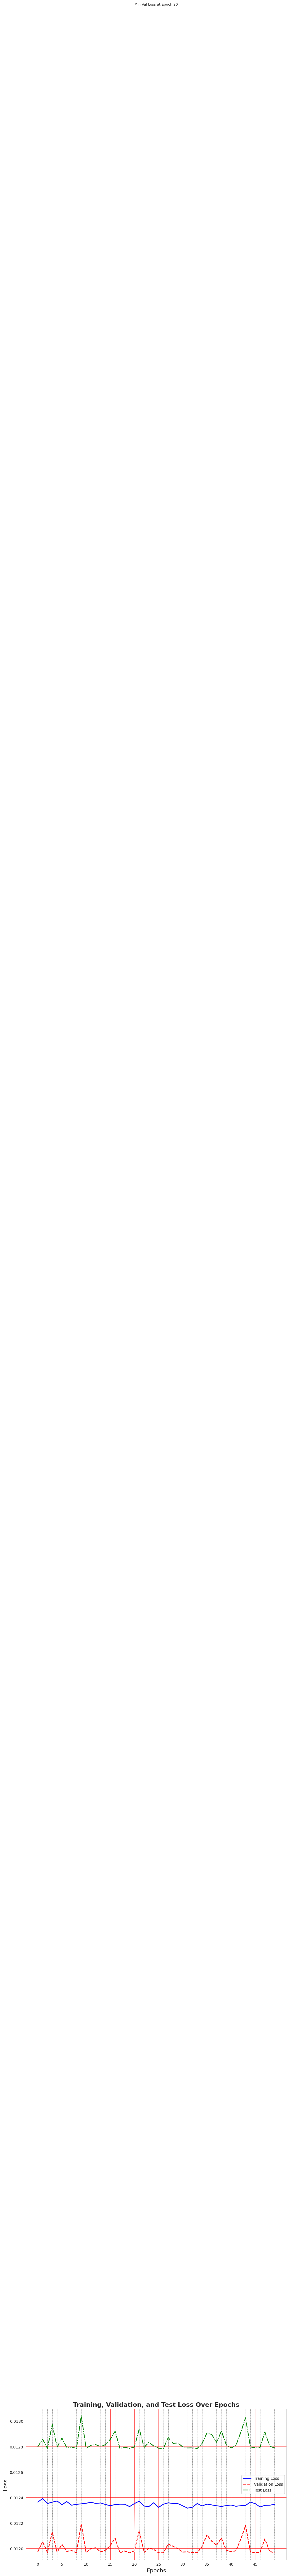

In [33]:
# Lists to store losses for each epoch
train_losses = []
val_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()
    val_losses.append(val_loss/len(val_loader))

    # test the model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            test_loss += loss.item()
    test_losses.append(test_loss/len(test_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Loss: {test_losses[-1]}")


# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the data
ax.plot(train_losses, label='Training Loss', color='blue', linestyle='-', linewidth=2)
ax.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2)
ax.plot(test_losses, label='Test Loss', color='green', linestyle='-.', linewidth=2)

# Highlight the epoch with the minimum validation loss
min_val_loss = min(val_losses)
min_val_epoch = np.argmin(val_losses) + 1  # +1 because epochs start from 1
ax.annotate(f'Min Val Loss at Epoch {min_val_epoch}',
            xy=(min_val_epoch, min_val_loss),
            xytext=(min_val_epoch, min_val_loss + 0.02),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=9)

# Set the title and labels
ax.set_title('Training, Validation, and Test Loss Over Epochs', fontsize=16, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.set_xticks(range(0, num_epochs, 5))
ax.set_xticks(range(num_epochs), minor=True)
ax.grid(which='both')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses
})

# Save to CSV
csv_path = "/content/drive/MyDrive/Colab_Notebooks/ADS_505/Module_3/losses.csv"
df.to_csv(csv_path, index=False)


In [35]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
# Evaluate on test set
model.eval()
val_predictions = []
actual_values = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        val_predictions.extend(outputs.numpy())
        actual_values.extend(y_batch.numpy())

mse = mean_squared_error(actual_values, val_predictions)
print(f"Mean Squared Error on Test Set: {mse}")


# We already computed MSE
print(f"Mean Squared Error (MSE): {mse}")

# Compute RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Compute MAE
mae = mean_absolute_error(actual_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Compute R-squared
r2 = r2_score(actual_values, val_predictions)
print(f"R-squared: {r2}")


actual_values_np = np.array(actual_values)
val_predictions_np = np.array(val_predictions)

#mask where actual value are not zero

mask = actual_values_np != 0


# Compute MAPE
mape = np.mean(np.abs((actual_values_np[mask] - val_predictions_np[mask]) / actual_values_np[mask])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error on Test Set: 0.012751146219670773
Mean Squared Error (MSE): 0.012751146219670773
Root Mean Squared Error (RMSE): 0.11292096972465515
Mean Absolute Error (MAE): 0.08301641792058945
R-squared: 0.002584180949410042
Mean Absolute Percentage Error (MAPE): 38.29369246959686%
